In [2]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.vaep as vaep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [5]:
games = pd.read_hdf(spadl_h5,"games")
print("nb of games:", len(games))

nb of games: 64


In [19]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        #.merge(players,how="left")
        .merge(teams,how="left",)
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:02<00:00, 22.60it/s]


Index(['game_id', 'period_id', 'action_id', 'time_seconds', 'timestamp',
       'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id', 'bodypart_id',
       'type_name', 'bodypart_name', 'team_name', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [15]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

passreceivalTrue         908
throw_inreceivalTrue      45
freekickreceivalTrue      23
clearancereceivalTrue     14
goalkickreceivalTrue       6
crossreceivalTrue          3
cornerreceivalTrue         1
dtype: int64

### Most valuable players

In [22]:
A["count"] = 1

# These are useless events that don't measure player skill
A_ = A[~A.type_name.isin(["penalty_shot","freekick_shot"])]
       
playersR = (
    A_[["player_id","vaep_value","offensive_value","defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id","player_nickname","player_name"]],how="left")
playersR["player"] = playersR[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id","player","vaep_value","offensive_value","defensive_value","count"]]
playersR.sort_values("vaep_value",ascending=False)[:10]

,player_id,player,vaep_value,offensive_value,defensive_value,count
44,3289.0,Romelu Lukaku,5.512703,5.418613,0.094089,400
6,3009.0,Kylian Mbappé,5.275791,4.975986,0.299805,721
122,4320.0,Neymar,5.184460,5.072523,0.111937,1118
92,3621.0,Eden Hazard,4.715666,4.527760,0.187906,1035
265,5487.0,Antoine Griezmann,4.503189,3.979384,0.523805,813
172,5207.0,Cristiano Ronaldo,4.452976,4.039180,0.413796,464
593,10955.0,Harry Kane,4.185696,4.643943,-0.458247,519
161,5195.0,Artem Dzyuba,4.176624,3.722728,0.453896,422
117,4269.0,Aleksandar Mitrović,4.105381,3.812958,0.292423,280
164,5198.0,Diego Costa,3.977347,3.899610,0.077737,271


In [23]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:25]

,player_id,player,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
117,4269.0,Aleksandar Mitrović,4.105381,3.812958,0.292423,280,271,1.363411,1.266296
34,3237.0,Sergio Agüero,2.920097,2.836556,0.083542,210,193,1.361703,1.322746
251,5473.0,Ahmed Musa,2.871012,2.182345,0.688667,244,220,1.174505,0.892777
164,5198.0,Diego Costa,3.977347,3.899610,0.077737,271,315,1.136385,1.114174
161,5195.0,Artem Dzyuba,4.176624,3.722728,0.453896,422,339,1.108838,0.988335
75,3531.0,Mohamed Salah,2.226051,2.199965,0.026086,181,189,1.060024,1.047602
172,5207.0,Cristiano Ronaldo,4.452976,4.039180,0.413796,464,381,1.051884,0.954137
152,5186.0,Denis Cheryshev,3.645216,4.095069,-0.449853,332,312,1.051505,1.181270
44,3289.0,Romelu Lukaku,5.512703,5.418613,0.094089,400,488,1.016687,0.999334
29,3196.0,Wahbi Khazri,2.966703,2.713411,0.253291,286,264,1.011376,0.925027


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-07-03 Colombia 1-1 England 255' receival 3445.0


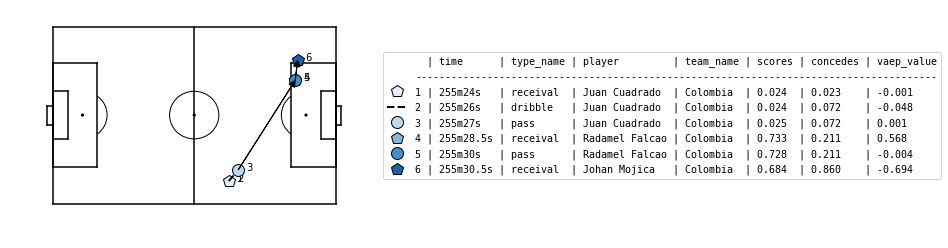

2018-06-24 England 6-1 Panama 39' receival 3532.0


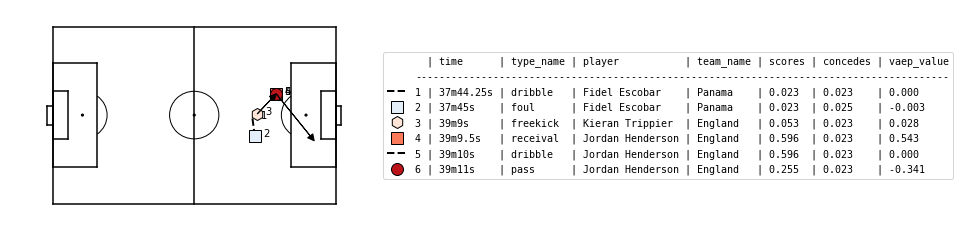

2018-06-27 South Korea 2-0 Germany 91' interception 5604.0


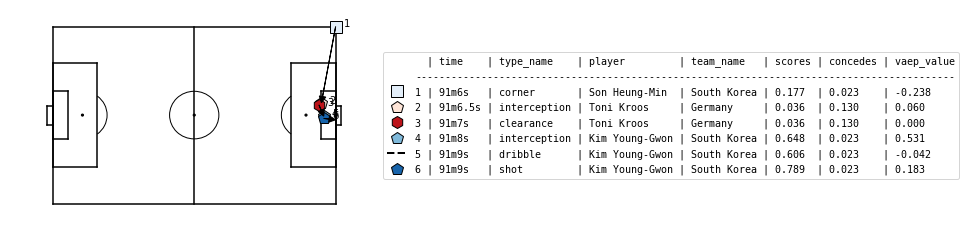

2018-07-01 Croatia 1-1 Denmark 256' pass 5522.0


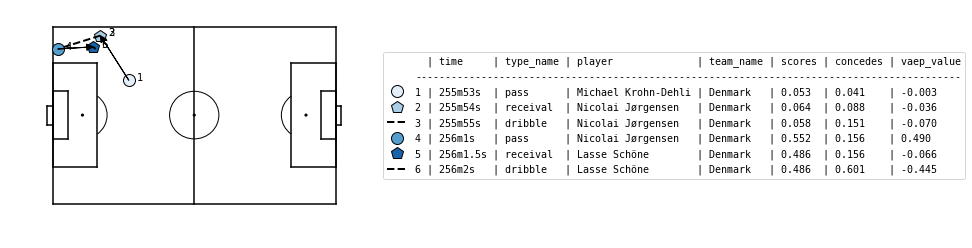

2018-06-24 England 6-1 Panama 41' pass 3233.0


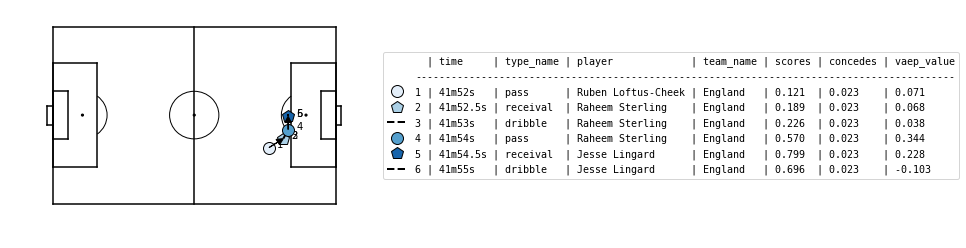

2018-06-27 Switzerland 2-2 Costa Rica 55' corner 5581.0


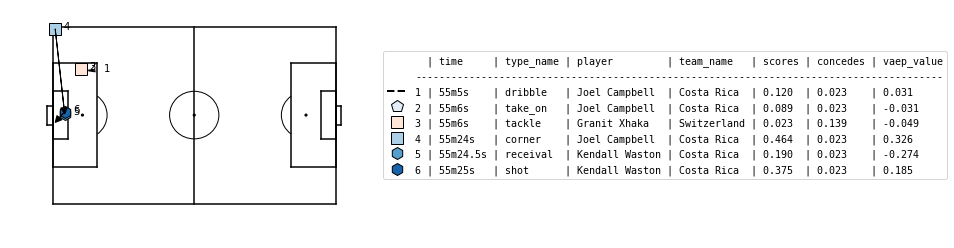

2018-07-15 France 4-2 Croatia 47' corner 5463.0


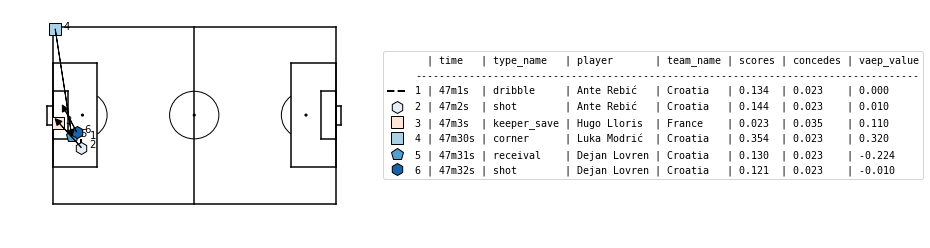

2018-07-03 Colombia 1-1 England 255' take_on 5691.0


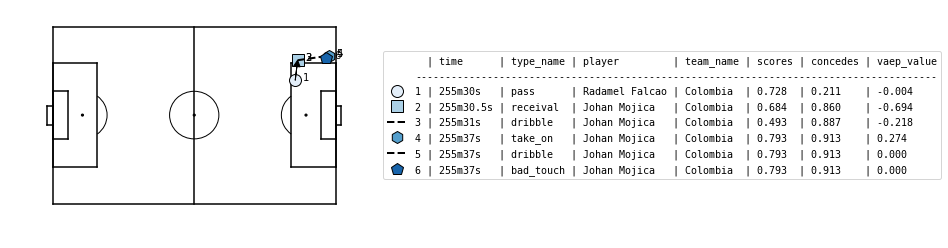

2018-07-02 Belgium 3-2 Japan 48' dribble 3621.0


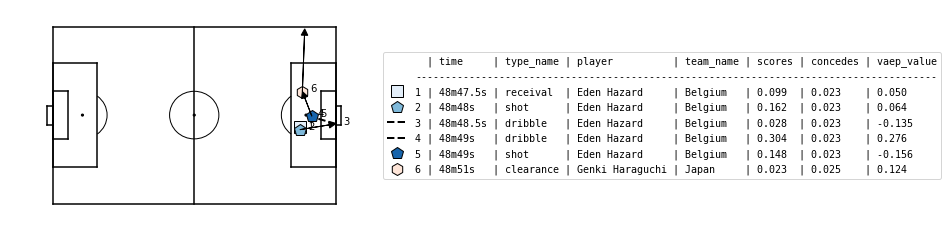

2018-07-02 Belgium 3-2 Japan 53' receival 5642.0


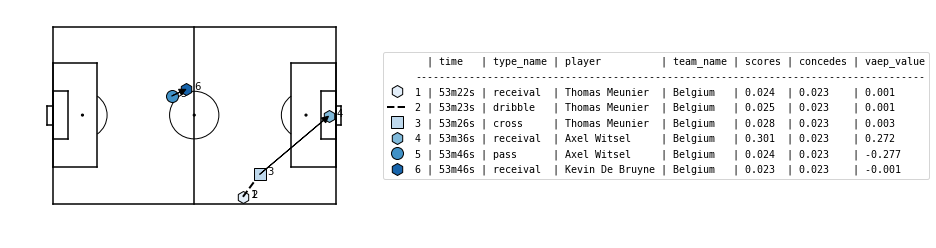

In [25]:
import matplotsoccer

players = pd.read_hdf(spadl_h5,"players")

sorted_A = A.sort_values("offensive_value", ascending=False)
#sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal","shot","shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+3].copy()
    
    a = a.merge(players,how="left")
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","concedes","vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x","y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                #result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)